This notebook is used to find the multipoles given a correlation function

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import ReadPinocchio as rp
from astropy.cosmology import FlatLambdaCDM as FLCDM
import scipy.interpolate as interp
import random
import hankl

# import seaborn

import mock_tools as mt
import cf_tools as cf

# from mcfit import P2xi

In [3]:
homedir=os.getcwd()

In [6]:
# resultsdir1=homedir+"/xirmu_old_norecon0"
resultsdir1 = homedir+'/xirmu_nz_recon3'
resultsdir  = homedir+"/xirmu_nz_norecon3"
# resultsdir  = homedir+"/xirmu_nz_norecon_periodic"
# resultsdir1 = homedir+"/xirmu_nz_norecon_nonperiodic"

# resultsdir=homedir+"/xirmu_norecon_radec0"
cambdir=homedir+'/../CAMB'
plcdir = homedir+'/../../Mocks_Pinocchio/001/plc'

In [7]:
bins = cf.make_xibins(rmin=40, rmax=160, binsize=5 )

dfbins = pd.DataFrame(bins)
dfbins.to_csv('r_bins.csv',header='r',index=False)

# Only one plot

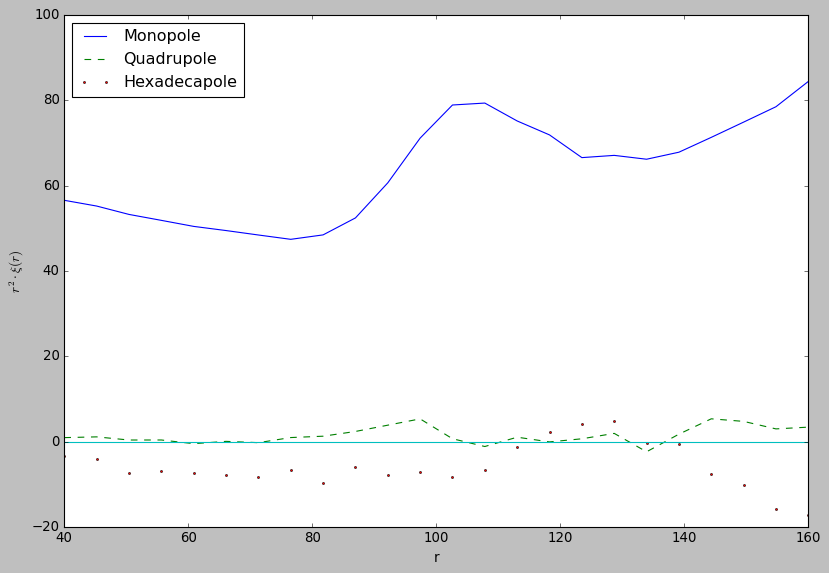

In [16]:
import cf_tools as cf


rmin, rmax, binsize = 40, 160, 5
r = cf.make_xibins(rmin, rmax, binsize)
xi_0_avg, xi_2_avg, xi_4_avg = cf.multipoles_avg(path=resultsdir1,mockmax=50,nmu=100,method=1)
# xi_0_avg1, xi_2_avg1, xi_4_avg1 = cf.multipoles_avg(path=resultsdir1,mockmax=50,nmu=100,method=1)




#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')

fig, ax = plt.subplots(figsize=(12,8))

# x=np.linspace(rmin,rmax,len(xi_0_avg))
x=r

#plt.ylim(-2e-3, 2e-3)
#plt.ylim(-5,5)
plt.xlim(rmin,rmax)

plt.xlabel("r")
plt.ylabel(r"$r^2\cdot \xi(r)$")
#ax.set_title('Monopolo')

# ax.plot(x,xi_0_avg,'-',x,xi_2_avg,'--',x,xi_4_avg,'o',markersize=1.9)
# ax.plot(x,xi_0_avg1,'-',x,xi_2_avg1,'--',x,xi_4_avg1,'o',markersize=1.9)

ax.plot(x,x**2*xi_0_avg,'-',x,x**2*xi_2_avg,'--',x,x**2*xi_4_avg,'o',markersize=1.9)
# ax.plot(x,x**2*xi_0_avg1,'-',x,x**2*xi_2_avg1,'--',x,x**2*xi_4_avg1,'o',markersize=1.9)

ax.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')
# ax.set_title("With "+ str(nmu)+" mu bins")

hor = [0]*len(x) 
ax.plot(x,hor)

plt.show()

# Comparing reconstructed and observed redshift

In [6]:
import cf_tools as cf


rmin, rmax, binsize = 40, 160, 5
r = cf.make_xibins(rmin, rmax, binsize)
xi_0_avg, xi_2_avg, xi_4_avg = cf.multipoles_avg(path=resultsdir,mockmax=50,nmu=100,method=1) #No recon
xi_0_avg1, xi_2_avg1, xi_4_avg1 = cf.multipoles_avg(path=resultsdir1,mockmax=50,nmu=100,method=1) #Recon

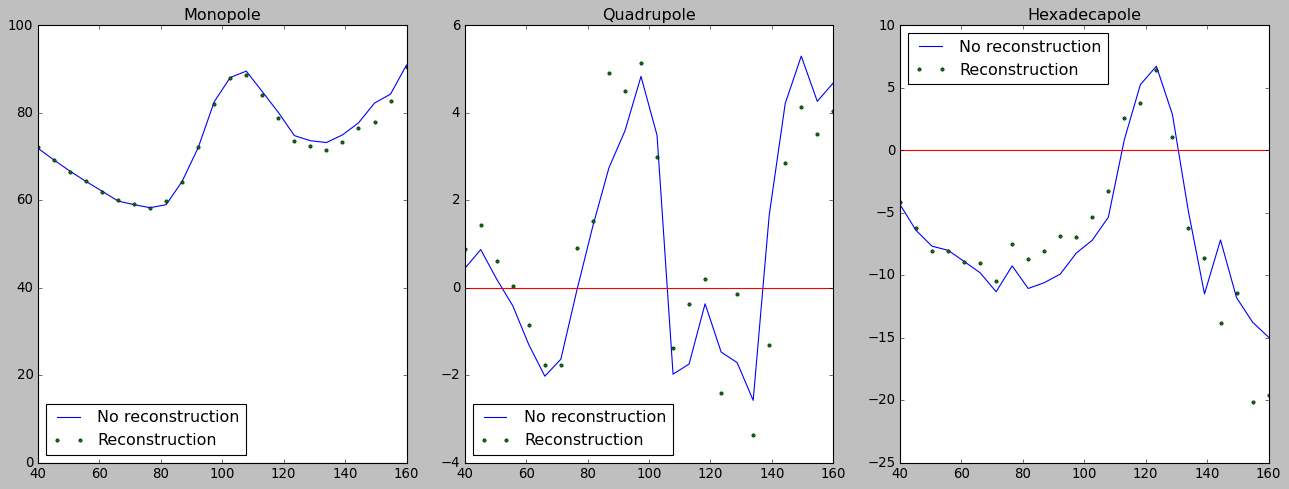

In [7]:
#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')

#first plot
fig=plt.figure(figsize=(16, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 3, left=0.05, right=0.5, wspace=0.05)

x = r
hor = [0]*len(x) 

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(r, r**2*xi_0_avg, r, r**2*xi_0_avg1, 'o', markersize=3.)
ax1.legend(["No reconstruction", "Reconstruction"],loc='best')
ax1.plot(x, hor)
ax1.set_title('Monopole')


ax2 = fig.add_subplot(gs[0,1])
ax2.plot(r, r**2*xi_2_avg, r, r**2*xi_2_avg1, 'o', markersize=3.)
ax2.legend(["No reconstruction", "Reconstruction"],loc='best')
ax2.plot(x,hor)
ax2.set_title('Quadrupole')


ax3 = fig.add_subplot(gs[0,2])
ax3.plot(r, r**2*xi_4_avg, r, r**2*xi_4_avg1, 'o', markersize=3.)
ax3.legend(["No reconstruction", "Reconstruction"],loc='best')
ax3.plot(x,hor)
ax3.set_title('Hexadecapole')


# plt.xlim(rmin,rmax)
# plt.xlabel("r")
# plt.ylabel(r"$r^2\cdot \xi(r)$")

# plt.xlim(rmin,rmax)
# plt.xlabel("r")
# plt.ylabel(r"$r^2\cdot \xi(r)$")
# ax.set_title("Without reconstruction")

plt.show()


# Theoretical multipoles

https://hankl.readthedocs.io/en/latest/examples.html

In [79]:
# b and f are free parameters.
def get_multipoles(pk_lin, b, f):

    p0 = (b*b + 2.0 * b *f / 3.0 + f*f/5.0 ) * pk_lin

    p2 = (4.0*b*f/3.0 + 4.0*f*f/7.0) * pk_lin

    p4 = (8.0* f*f / 35.0) * pk_lin

    return p0, p2, p4

In [81]:
cambname = 'camb_07796713_matterpower_z0.55.csv'

os.chdir(cambdir)
pk_camb_df = pd.read_csv(cambname, names = ['k', 'pk'])
pk_camb = pk_camb_df.to_numpy()
k  = pk_camb[:,0]
pk = pk_camb[:,1]

klog = np.logspace(np.log10(k.min()), np.log10(k.max()), k.size) #log spaced k's
pklog = np.interp(klog, k, pk) #evaluate pk at log spaced k

p0, p2, p4 = get_multipoles(pk_lin = pklog, b = 2.0, f = 0.5)

s, xir_th_0 = hankl.P2xi(klog, p0, l=0)
s, xir_th_2 = hankl.P2xi(klog, p2, l=2)
s, xir_th_4 = hankl.P2xi(klog, p4, l=4)

C:\Users\Pedro\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


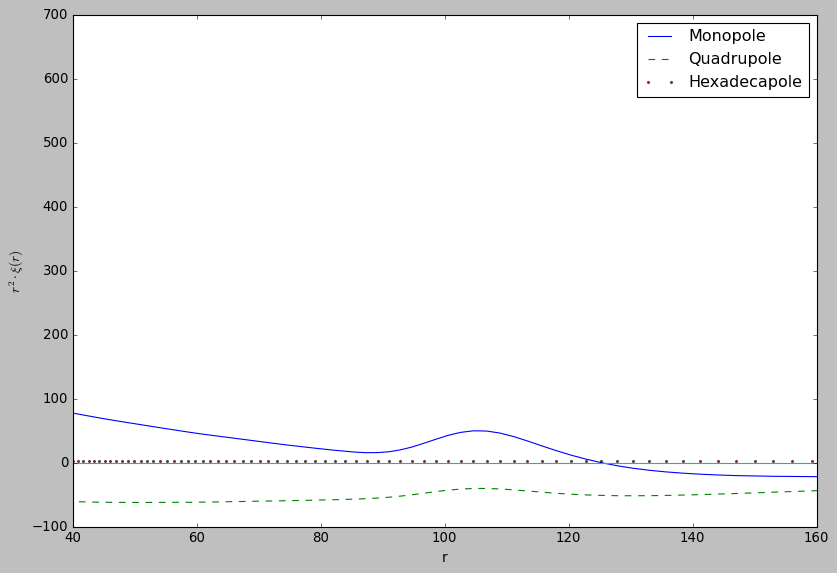

In [85]:

#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')

fig, ax = plt.subplots(figsize=(12,8))

# x=np.linspace(rmin,rmax,len(xi_0_avg))
x = s

# plt.ylim(-2e-3, 2e-3)
# plt.ylim(-5,5)
plt.xlim(40,160)

plt.xlabel("r")
plt.ylabel(r"$r^2\cdot \xi(r)$")
#ax.set_title('Monopolo')

# ax.plot(x,xi_0_avg,'-',x,xi_2_avg,'--',x,xi_4_avg,'o',markersize=1.9)
# ax.plot(x,xi_0_avg1,'-',x,xi_2_avg1,'--',x,xi_4_avg1,'o',markersize=1.9)

ax.plot(x,x**2*xir_th_0,'-',x,x**2*xir_th_2,'--',x,x**2*xir_th_4,'o',markersize=1.9)
# ax.plot(x,x**2*xi_0_avg1,'-',x,x**2*xi_2_avg1,'--',x,x**2*xi_4_avg1,'o',markersize=1.9)

ax.legend(["Monopole","Quadrupole","Hexadecapole"],loc='best')
# ax.set_title("With "+ str(nmu)+" mu bins")

hor = [0]*len(x) 
ax.plot(x,hor)

plt.show()

# Theoretical model vs. Data points

In [87]:
# b and f are free parameters.
def get_multipoles(pk_lin, b, f):

    p0 = (b*b + 2.0 * b *f / 3.0 + f*f/5.0 ) * pk_lin

    p2 = (4.0*b*f/3.0 + 4.0*f*f/7.0) * pk_lin

    p4 = (8.0* f*f / 35.0) * pk_lin

    return p0, p2, p4

cambname = 'camb_07796713_matterpower_z0.55.csv'

os.chdir(cambdir)
pk_camb_df = pd.read_csv(cambname, names = ['k', 'pk'])
pk_camb = pk_camb_df.to_numpy()
k  = pk_camb[:,0]
pk = pk_camb[:,1]

klog = np.logspace(np.log10(k.min()), np.log10(k.max()), k.size) #log spaced k's
pklog = np.interp(klog, k, pk) #evaluate pk at log spaced k

p0, p2, p4 = get_multipoles(pk_lin = pklog, b = 2.0, f = 0.5)

s, xir_th_0 = hankl.P2xi(klog, p0, l=0)
s, xir_th_2 = hankl.P2xi(klog, p2, l=2)
s, xir_th_4 = hankl.P2xi(klog, p4, l=4)

In [88]:
import cf_tools as cf

rmin, rmax, binsize = 40, 160, 5
r = cf.make_xibins(rmin, rmax, binsize)
xi_0_avg, xi_2_avg, xi_4_avg = cf.multipoles_avg(path=resultsdir,mockmax=50,nmu=100,method=1) #No recon

C:\Users\Pedro\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Pedro\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Pedro\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


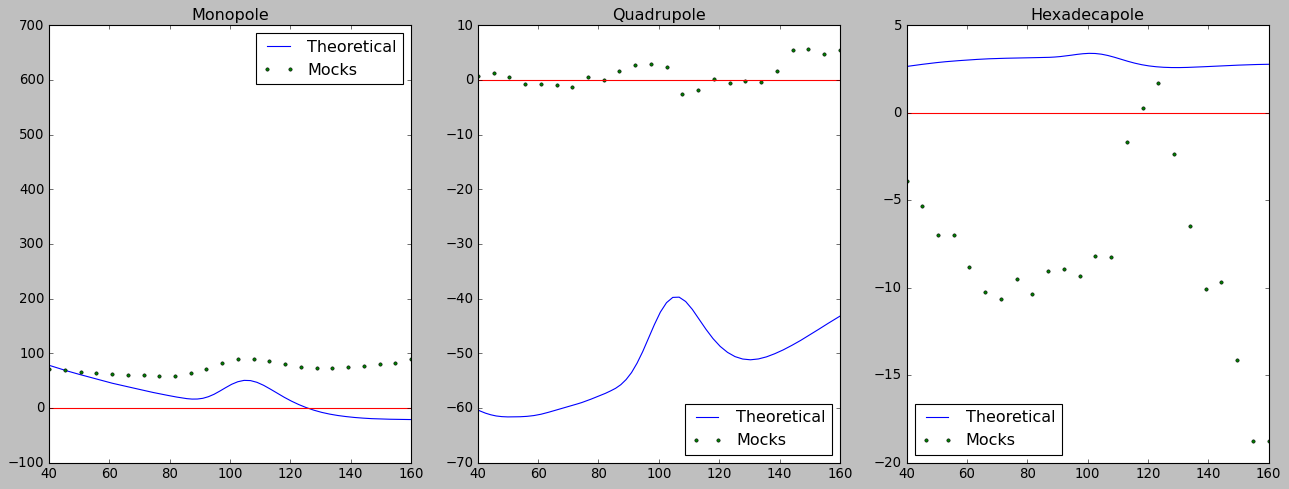

In [92]:
#################################### make plot ####################################
#plot the multipoles
plt.style.use('classic')

#first plot
fig=plt.figure(figsize=(16, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 3, left=0.05, right=0.5, wspace=0.05)

x = r
hor = [0]*len(x) 

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(s, s**2*xir_th_0, r, r**2*xi_0_avg, 'o', markersize=3.)
ax1.legend(["Theoretical", "Mocks"],loc='best')
ax1.plot(x, hor)
ax1.set_title('Monopole')
ax1.set_xlim(40,160)


ax2 = fig.add_subplot(gs[0,1])
ax2.plot(s, s**2*xir_th_2, r, r**2*xi_2_avg, 'o', markersize=3.)
ax2.legend(["Theoretical", "Mocks"],loc='best')
ax2.plot(x,hor)
ax2.set_title('Quadrupole')
ax2.set_xlim(40,160)

ax3 = fig.add_subplot(gs[0,2])
ax3.plot(s, s**2*xir_th_4, r, r**2*xi_4_avg, 'o', markersize=3.)
ax3.legend(["Theoretical", "Mocks"],loc='best')
ax3.plot(x,hor)
ax3.set_title('Hexadecapole')
ax3.set_xlim(40,160)

plt.show()
